In [1]:
import os
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as layers

import gym
from gym import spaces
from PIL import Image
from collections import deque, namedtuple
from IPython.display import HTML
from IPython import display
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

/Users/mathemage/anaconda3/envs/tf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/mathemage/anaconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from environments import Snake
from visual_utils import AgentViz
from methods import ReflexDistQNetwork,  ReplayMemory

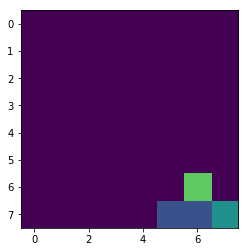

In [3]:
s = Snake()
img = s.reset()
s.plot_state()

In [13]:
class SnakeAgent:
    
    def __init__(self, num_atoms=21, reflex=3, model_name="baseline_agent"):
        
        """Class for training and evaluating DQN agent on Atari games
        
        Parameters
        ----------
        game_id: str
            game identifier in gym environment, e.g. "Pong"
        num_actions: int
            number of actions the agent can take
        model_name: str
            name of the model
        """
        
        ############################ Game environment ############################
        
        self.train_env = Snake()
        self.num_actions = 4
        self.reflex = reflex
            
        self.path = "snake_models" + "/" + model_name
        if not os.path.exists(self.path):
            os.makedirs(self.path)
        
        ############################# Agent & Target #############################
        
        tf.reset_default_graph()
        self.agent_net = ReflexDistQNetwork(self.num_actions, num_atoms=num_atoms, reflex=reflex, scope="agent")
        self.target_net = ReflexDistQNetwork(self.num_actions, num_atoms=num_atoms, reflex=reflex, scope="target")
        
        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        
        all_vars = tf.trainable_variables()
        num_vars = len(all_vars) // 2
        self.agent_vars = all_vars[:num_vars]
        self.target_vars = all_vars[num_vars:]
        
    def set_parameters(self, 
                       replay_memory_size=50000,
                       replay_start_size=10000,
                       init_eps=1,
                       final_eps=0.1,
                       annealing_steps=100000,
                       discount_factor=0.99,
                       max_episode_length=2000):
        
        # create experience replay and fill it with random policy samples
        self.rep_buffer = ReplayMemory(replay_memory_size)
        frame_count = 0
        while (frame_count < replay_start_size):
            s = self.train_env.reset()
            for time_step in range(max_episode_length):
                a = np.random.randint(self.num_actions)
                s_, r, end = self.train_env.step(a)
                self.rep_buffer.push(s, a, np.sign(r), s_, end)
                s = s_
                frame_count += 1
                if end:
                    break
                        
        self.eps = init_eps
        self.final_eps = final_eps
        self.eps_drop = (init_eps - final_eps) / annealing_steps
        self.gamma = discount_factor
        self.max_ep_length = max_episode_length
        
    def train(self,
              gpu_id=0,
              batch_size=32,
              agent_update_freq=4,
              target_update_freq=5000,
              tau=1,
              max_num_episodes=100000,
              max_num_epochs=50000,
              performance_print_freq=100,
              save_freq=10000):
        
        target_ops = self.update_target_graph(tau)
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(config=config) as sess:
            sess.run(self.init)
            
            train_rewards = []
            frame_count = 0
            episode_count = 0
            num_epochs = 0
            
            while num_epochs < max_num_epochs:
                
                train_ep_reward = 0
                
                # reset the environment / start new game
                s = self.train_env.reset()
                for time_step in range(self.max_ep_length):
                    
                    # get sequence of actions using lstm
                    if np.random.rand() < self.eps:
                        a = np.random.randint(0, self.num_actions, size=(self.reflex, ))
                    a = self.agent_net.get_action_seq(sess, [s])[0]
                    total_r = 0
                    for a_idx, a_ in enumerate(a):
                        s_, r, end = self.train_env.step(a_)
                        total_r += (self.gamma**a_idx) * np.sign(r)
                        if end: break
                    
                    r = total_r
                                    
                    # save transition into experience replay
                    self.rep_buffer.push(s, a[0], r, s_, end)
                    
                    # update current state and statistics
                    s = s_
                    frame_count += 1
                    train_ep_reward += r
                    
                    # reduce epsilon according to schedule
                    if self.eps > self.final_eps:
                        self.eps -= self.eps_drop
                    
                    # update network weights
                    if frame_count % agent_update_freq == 0:
                        
                        batch = self.rep_buffer.get_batch(batch_size)
                        
                        # estimate right hand side of the Bellman equation
                        max_actions = self.agent_net.get_q_argmax(sess, batch.s_)
                        target_m = self.target_net.cat_proj(sess, batch.r, batch.s_, 
                                                            max_actions, batch.end)
                        
                        # update agent network
                        self.agent_net.update(sess, batch.s, batch.a, target_m)
                        
                        # update target network
                        if tau == 1:
                            if frame_count % target_update_freq == 0:
                                self.update_target_weights(sess, target_ops)
                        else: self.update_target_weights(sess, target_ops)
                    
                    # make checkpoints of network weights and save learning curve
                    if frame_count % save_freq == 1:
                        num_epochs += 1
                        try:
                            self.saver.save(sess, self.path+"/model", global_step=num_epochs)
                            np.savez(self.path+"/learning_curve.npz", r=train_rewards)
                        except:
                            pass
                    
                    # if game is over, reset the environment
                    if end: 
                        break
                         
                episode_count += 1
                train_rewards.append(train_ep_reward)
                
                # print performance once in a while
                if episode_count % performance_print_freq == 0:
                    avg_reward = np.mean(train_rewards[-performance_print_freq:])
                    max_reward = np.max(train_rewards[-performance_print_freq:])
                    print("Train info:", frame_count, avg_reward, max_reward)  

    def update_target_graph(self, tau):
        op_holder = []
        for agnt, trgt in zip(self.agent_vars, self.target_vars):
            op = trgt.assign(agnt.value()*tau + (1 - tau)*trgt.value())
            op_holder.append(op)
        return op_holder

    def update_target_weights(self, sess, op_holder):
        for op in op_holder:
            sess.run(op)

In [14]:
aa = SnakeAgent(model_name="baseline_reflqn")

In [15]:
aa.set_parameters(max_episode_length=50000, replay_memory_size=50000, replay_start_size=10000)

In [ ]:
aa.train(gpu_id=0)

Train info: 174 -0.9803320000000001 0.01990000000000003
Train info: 374 -0.972223 0.010000000000000009
Train info: 570 -0.9026209999999999 0.01990000000000003
Train info: 757 -0.9530189999999998 0.01990000000000003
Train info: 929 -0.9414219999999999 0.01990000000000003
Train info: 1113 -0.912824 0.01990000000000003
Train info: 1288 -0.9408299999999999 0.01990000000000003
Train info: 1470 -0.9316299999999998 0.01990000000000003
Train info: 1655 -0.9126240000000001 0.010000000000000009
Train info: 1844 -0.9225209999999998 0.01990000000000003
Train info: 2039 -0.9114260000000001 0.01990000000000003
Train info: 2215 -0.9205300000000001 0.01990000000000003
Train info: 2406 -0.9226199999999999 0.01990000000000003
Train info: 2587 -0.9720210000000001 0.010000000000000009
Train info: 2760 -0.9016239999999999 0.99
Train info: 2935 -0.9413279999999999 0.01990000000000003
Train info: 3106 -0.9402349999999999 1.0099
Train info: 3295 -0.960531 0.01990000000000003
Train info: 3479 -0.940732 0.01990